Complete ordinal encoder and encode date, run remaining

# Check tomorrow first
https://scikit-learn.org/stable/modules/learning_curve.html
https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

In [10]:
file = 'Rainfall.csv'
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score, mean_absolute_error
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [11]:
class EDA:
    
    def __init__(self):
        
        self.target = None
        self.df = None
        
    def describe(self):
        
        sep = lambda x : '+=+'*15 + '     ' + str(x) + '     ' + '+=+' * 15
        print(sep('INFO'))
        print(self.df.info())
        print(sep('DESCRIBE'))
        print(self.df.describe())
        print(sep('NULL VALUE COUNTS'))
        print(self.df.isnull().sum())
        
        
        
    def all_val_cnts(self):
        for col in self.df.columns:
            print('=+'*30)
            print(self.df[col].value_counts())
            
    def all_col_histplots(self,df = None):
        
        if df == None:
            df = self.df
        plt.figure(figsize=(20,100),facecolor='white')
        plotnum = 1

        for col in df.columns:
            if plotnum < 14:
                ax = plt.subplot(14,1,plotnum)
                sns.histplot(df[col])
                plt.xlabel(col)
            plotnum += 1
        plt.tight_layout()
    def corr_plot(self, df = None):
        
        df_corr = df.corr()
        plt.figure(figsize=(25,25))
        sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True, square=True, center=0,fmt='.2g',linewidths=0.1)
        plt.tight_layout()
        
    def get_vif(self, df = None):
        
        
        if type(df) != pd.DataFrame:
            df = self.df
        vif = pd.DataFrame()
        vif['values'] = [variance_inflation_factor(df.values,i) for i in range(len(df.columns))] 
        vif['features'] = df.columns
        print(vif)
        return vif
    
    

    
    def check_skew(self, df = None):
        
        if type(df) != pd.DataFrame:
            df = self.df[[col for col in self.df.columns if self.df[col].dtype == 'int' or self.df[col].dtype == 'float']]
        print(self.df.skew())
        
    def reduce_skewness(self, X = None):
        
        if type(X) != pd.DataFrame:
            X = self.df.drop(columns = [self.target])
        for col,skew in dict(X.skew()).items():
            print(col)
            if skew > 0.5 or skew < 0.5:
                X[col] = np.cbrt(X[col])
                X[col].fillna(np.mean(X[col]),inplace=True)
        return X

        

In [56]:
        
class Encoder:
    
    def __init__(self,df):
        self.df = df
    
    def label(self, df = None,cols = []):
        if type(df) != pd.DataFrame:
            df = self.df
        encoder = LabelEncoder()
        for col in cols:
            self.df[col] = encoder.fit_transform(self.df[col])
        return self.df
    
    def standard_scaler(self, df = None):
        if type(df) != pd.DataFrame:
            df = self.df
        scalar = StandardScaler()
        cols = df.columns
        df = scalar.fit_transform(df)
        df = pd.DataFrame(df, columns=cols)
        return df
    
    def do_yeo(self, X = None):
        for col in X.columns:
            if X[col].skew() > 0.5:
                X[col],_ = stats.yeojohnson(X[col])
            elif X[col].skew() < -0.5:
                X[col],_ = stats.yeojohnson(X[col])
        return X
    
    def sqrt_transform(self, X):
        if type(X) != pd.DataFrame:
            X = self.df.drop(columns=[self.target])
        for col in X.columns:
            if X[col].skew() > 0.5:
#                 while X[col].skew() > 1:
                X[col] = np.sqrt(X[col])
            elif X[col].skew() < -0.5:
#                 while X[col].skew() < -1:
                X[col] = np.sqrt(X[col])
        return X
    
    def ordinal_encode(self, df):
        encoder = OrdinalEncoder()
        
        df = encoder.fit_transform(df)
        return df

In [13]:
df = pd.read_csv(file)
eda = EDA()
eda.df = df


In [14]:
eda.all_val_cnts()

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Date
2011-01-31    5
2011-05-08    5
2011-05-21    5
2011-05-20    5
2011-05-19    5
             ..
2013-01-28    1
2013-01-29    1
2013-01-30    1
2013-01-31    1
2013-06-08    1
Name: count, Length: 3004, dtype: int64
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Location
Melbourne       1622
Williamtown     1230
PerthAirport    1204
Albury           907
Newcastle        822
CoffsHarbour     611
Brisbane         579
Penrith          482
Wollongong       474
Darwin           250
Adelaide         205
Uluru             39
Name: count, dtype: int64
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
MinTemp
 12.0    74
 13.2    71
 13.8    69
 12.7    68
 16.4    67
         ..
 0.3      1
 28.3     1
-1.1      1
-1.4      1
 26.0     1
Name: count, Length: 285, dtype: int64
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
MaxTemp
19.0    87
23.8    75
19.8    74
25.0    71
22.0    68
      

Let's convert date to datetime

In [15]:
df['Date'] = pd.to_datetime(df['Date'])

###### We can make the prediction more robust by replacing the actual today's rainfall with yesterday's prediction since the data is actually true. 

In [16]:
grps = df.groupby('Location')

In [17]:
for grp in grps:
    for key, val in grps:
        indexes = val.index.to_list()
        for i in range(len(indexes)-1):
            df.loc[indexes[i], 'Rainfall_quantity_tomorrow'] = df.loc[indexes[i+1],'Rainfall']
            df.loc[indexes[i], 'Rainfall_tomorrow_pred'] = df.loc[indexes[i+1],'RainTomorrow']

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        8425 non-null   datetime64[ns]
 1   Location                    8425 non-null   object        
 2   MinTemp                     8350 non-null   float64       
 3   MaxTemp                     8365 non-null   float64       
 4   Rainfall                    8185 non-null   float64       
 5   Evaporation                 4913 non-null   float64       
 6   Sunshine                    4431 non-null   float64       
 7   WindGustDir                 7434 non-null   object        
 8   WindGustSpeed               7434 non-null   float64       
 9   WindDir9am                  7596 non-null   object        
 10  WindDir3pm                  8117 non-null   object        
 11  WindSpeed9am                8349 non-null   float64     

Target1 is regression and Target2 is classification

In [19]:
target1, target2 = 'Rainfall_quantity_tomorrow','Rainfall_tomorrow_pred'

In [20]:
df[df['Rainfall']==0]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_quantity_tomorrow,Rainfall_tomorrow_pred
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No,0.0,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No,0.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0,No
8421,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0,No
8422,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0,No
8423,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No,0.0,NaN


we can see that we have very limited number of values for rainfall. So we have to inflate the count using smote

In [21]:
eda.describe()

+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+     INFO     +=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        8425 non-null   datetime64[ns]
 1   Location                    8425 non-null   object        
 2   MinTemp                     8350 non-null   float64       
 3   MaxTemp                     8365 non-null   float64       
 4   Rainfall                    8185 non-null   float64       
 5   Evaporation                 4913 non-null   float64       
 6   Sunshine                    4431 non-null   float64       
 7   WindGustDir                 7434 non-null   object        
 8   WindGustSpeed               7434 non-null   float64       
 9   WindDir9am                  7596 non-null   object        
 10  WindDir3pm     

In [24]:
df.shape

(8425, 25)

In [25]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Rainfall_quantity_tomorrow',
       'Rainfall_tomorrow_pred'],
      dtype='object')

In [26]:
df['Date']

0      2008-12-01
1      2008-12-02
2      2008-12-03
3      2008-12-04
4      2008-12-05
          ...    
8420   2017-06-21
8421   2017-06-22
8422   2017-06-23
8423   2017-06-24
8424   2017-06-25
Name: Date, Length: 8425, dtype: datetime64[ns]

In [27]:
df.dropna(subset=['Rainfall_tomorrow_pred','Rainfall_quantity_tomorrow']).isnull().sum()

Date                             0
Location                         0
MinTemp                         60
MaxTemp                         34
Rainfall                        99
Evaporation                   3391
Sunshine                      3842
WindGustDir                    948
WindGustSpeed                  948
WindDir9am                     801
WindDir3pm                     284
WindSpeed9am                    61
WindSpeed3pm                    85
Humidity9am                     44
Humidity3pm                     82
Pressure9am                   1283
Pressure3pm                   1284
Cloud9am                      2263
Cloud3pm                      2299
Temp9am                         41
Temp3pm                         76
RainToday                       99
RainTomorrow                     0
Rainfall_quantity_tomorrow       0
Rainfall_tomorrow_pred           0
dtype: int64

In [28]:
df.dtypes

Date                          datetime64[ns]
Location                              object
MinTemp                              float64
MaxTemp                              float64
Rainfall                             float64
Evaporation                          float64
Sunshine                             float64
WindGustDir                           object
WindGustSpeed                        float64
WindDir9am                            object
WindDir3pm                            object
WindSpeed9am                         float64
WindSpeed3pm                         float64
Humidity9am                          float64
Humidity3pm                          float64
Pressure9am                          float64
Pressure3pm                          float64
Cloud9am                             float64
Cloud3pm                             float64
Temp9am                              float64
Temp3pm                              float64
RainToday                             object
RainTomorr

In [29]:
for ind in df.dtypes.index:
    if df.dtypes.loc[ind] == 'object':
        print(df[ind].value_counts())
        print(df[ind].unique())
        print(df[ind].isnull().sum())

Location
Melbourne       1622
Williamtown     1230
PerthAirport    1204
Albury           907
Newcastle        822
CoffsHarbour     611
Brisbane         579
Penrith          482
Wollongong       474
Darwin           250
Adelaide         205
Uluru             39
Name: count, dtype: int64
['Albury' 'CoffsHarbour' 'Newcastle' 'Penrith' 'Williamtown' 'Wollongong'
 'Melbourne' 'Brisbane' 'Adelaide' 'PerthAirport' 'Darwin' 'Uluru']
0
WindGustDir
N      713
SSE    578
S      577
SW     572
E      557
WNW    531
W      507
WSW    504
SE     484
ENE    415
SSW    396
NW     383
NE     353
NNE    343
ESE    302
NNW    219
Name: count, dtype: int64
['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']
991
WindDir9am
N      906
SW     704
NW     625
WSW    543
SE     505
WNW    480
SSW    467
ENE    433
NNE    430
W      414
NE     409
S      402
E      380
SSE    365
NNW    280
ESE    253
Name: count, dtype: int64
['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' nan '

In [30]:
df.dropna(subset=['Rainfall_tomorrow_pred','Rainfall_quantity_tomorrow'],inplace=True)

In [31]:
encoder = OrdinalEncoder()

dfx = encoder.fit_transform(df)
dfo = pd.DataFrame(dfx,columns = df.columns)

In [32]:
df.Rainfall_tomorrow_pred.unique() 

array(['No', 'Yes'], dtype=object)

In [33]:
dfo.WindDir3pm.unique()

array([14., 15.,  0.,  7., 13., 10.,  2.,  1.,  6., 12.,  9.,  3., 11.,
        8.,  5., nan,  4.])

In [34]:
dfo

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_quantity_tomorrow,Rainfall_tomorrow_pred
0,0.0,1.0,149.0,134.0,5.0,NaN,NaN,13.0,20.0,13.0,...,88.0,101.0,8.0,NaN,145.0,133.0,0.0,0.0,0.0,0.0
1,1.0,1.0,89.0,156.0,0.0,NaN,NaN,14.0,20.0,6.0,...,117.0,108.0,NaN,NaN,148.0,158.0,0.0,0.0,0.0,0.0
2,2.0,1.0,144.0,162.0,0.0,NaN,NaN,15.0,21.0,13.0,...,87.0,117.0,NaN,2.0,186.0,147.0,0.0,0.0,0.0,0.0
3,3.0,1.0,107.0,185.0,0.0,NaN,NaN,4.0,9.0,9.0,...,187.0,158.0,NaN,NaN,157.0,180.0,0.0,0.0,8.0,0.0
4,4.0,1.0,190.0,228.0,8.0,NaN,NaN,13.0,18.0,1.0,...,119.0,90.0,7.0,8.0,154.0,212.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,2949.0,9.0,89.0,111.0,0.0,NaN,NaN,0.0,15.0,2.0,...,283.0,263.0,NaN,NaN,86.0,118.0,0.0,0.0,0.0,0.0
8064,2950.0,9.0,50.0,123.0,0.0,NaN,NaN,0.0,13.0,2.0,...,258.0,242.0,NaN,NaN,70.0,124.0,0.0,0.0,0.0,0.0
8065,2951.0,9.0,43.0,139.0,0.0,NaN,NaN,0.0,13.0,9.0,...,257.0,233.0,NaN,NaN,77.0,139.0,0.0,0.0,0.0,0.0
8066,2952.0,9.0,51.0,158.0,0.0,NaN,NaN,6.0,8.0,9.0,...,246.0,221.0,NaN,NaN,85.0,160.0,0.0,0.0,0.0,0.0


In [35]:
print(encoder.inverse_transform(dfx))

[[1228089600000000000 'Albury' 13.4 ... 'No' 0.0 'No']
 [1228176000000000000 'Albury' 7.4 ... 'No' 0.0 'No']
 [1228262400000000000 'Albury' 12.9 ... 'No' 0.0 'No']
 ...
 [1498003200000000000 'Uluru' 2.8 ... 'No' 0.0 'No']
 [1498089600000000000 'Uluru' 3.6 ... 'No' 0.0 'No']
 [1498176000000000000 'Uluru' 5.4 ... 'No' 0.0 'No']]


In [36]:
imputer = KNNImputer(n_neighbors=20)
imputer.fit(dfo)
dfi = imputer.transform(dfo)
dfi = pd.DataFrame(dfi,columns=dfo.columns)

In [37]:
len(df.Date.unique())

2956

In [38]:
len(dfi.Date.unique())

2956

In [39]:
dfi.isnull().sum()

Date                          0
Location                      0
MinTemp                       0
MaxTemp                       0
Rainfall                      0
Evaporation                   0
Sunshine                      0
WindGustDir                   0
WindGustSpeed                 0
WindDir9am                    0
WindDir3pm                    0
WindSpeed9am                  0
WindSpeed3pm                  0
Humidity9am                   0
Humidity3pm                   0
Pressure9am                   0
Pressure3pm                   0
Cloud9am                      0
Cloud3pm                      0
Temp9am                       0
Temp3pm                       0
RainToday                     0
RainTomorrow                  0
Rainfall_quantity_tomorrow    0
Rainfall_tomorrow_pred        0
dtype: int64

In [40]:
dfi.reset_index(inplace=True, drop=True)

In [41]:
df = dfi.copy()

In [42]:
df.shape

(8068, 25)

In [43]:
df[~df['Evaporation'].isnull()]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_quantity_tomorrow,Rainfall_tomorrow_pred
0,0.0,1.0,149.0,134.0,5.0,115.0,140.0,13.0,20.0,13.0,...,88.0,101.0,8.0,9.0,145.0,133.0,0.0,0.0,0.0,0.0
1,1.0,1.0,89.0,156.0,0.0,115.0,140.0,14.0,20.0,6.0,...,117.0,108.0,9.0,9.0,148.0,158.0,0.0,0.0,0.0,0.0
2,2.0,1.0,144.0,162.0,0.0,115.0,140.0,15.0,21.0,13.0,...,87.0,117.0,9.0,2.0,186.0,147.0,0.0,0.0,0.0,0.0
3,3.0,1.0,107.0,185.0,0.0,115.0,140.0,4.0,9.0,9.0,...,187.0,158.0,9.0,9.0,157.0,180.0,0.0,0.0,8.0,0.0
4,4.0,1.0,190.0,228.0,8.0,115.0,140.0,13.0,18.0,1.0,...,119.0,90.0,7.0,8.0,154.0,212.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,2949.0,9.0,89.0,111.0,0.0,115.0,140.0,0.0,15.0,2.0,...,283.0,263.0,9.0,9.0,86.0,118.0,0.0,0.0,0.0,0.0
8064,2950.0,9.0,50.0,123.0,0.0,115.0,140.0,0.0,13.0,2.0,...,258.0,242.0,9.0,9.0,70.0,124.0,0.0,0.0,0.0,0.0
8065,2951.0,9.0,43.0,139.0,0.0,115.0,140.0,0.0,13.0,9.0,...,257.0,233.0,9.0,9.0,77.0,139.0,0.0,0.0,0.0,0.0
8066,2952.0,9.0,51.0,158.0,0.0,115.0,140.0,6.0,8.0,9.0,...,246.0,221.0,9.0,9.0,85.0,160.0,0.0,0.0,0.0,0.0


In [44]:
eda = EDA()

In [45]:
eda.df = df

In [46]:
eda.describe()

+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+     INFO     +=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        8068 non-null   float64
 1   Location                    8068 non-null   float64
 2   MinTemp                     8068 non-null   float64
 3   MaxTemp                     8068 non-null   float64
 4   Rainfall                    8068 non-null   float64
 5   Evaporation                 8068 non-null   float64
 6   Sunshine                    8068 non-null   float64
 7   WindGustDir                 8068 non-null   float64
 8   WindGustSpeed               8068 non-null   float64
 9   WindDir9am                  8068 non-null   float64
 10  WindDir3pm                  8068 non-null   float64
 11  WindSpeed9am                8068 non-null 

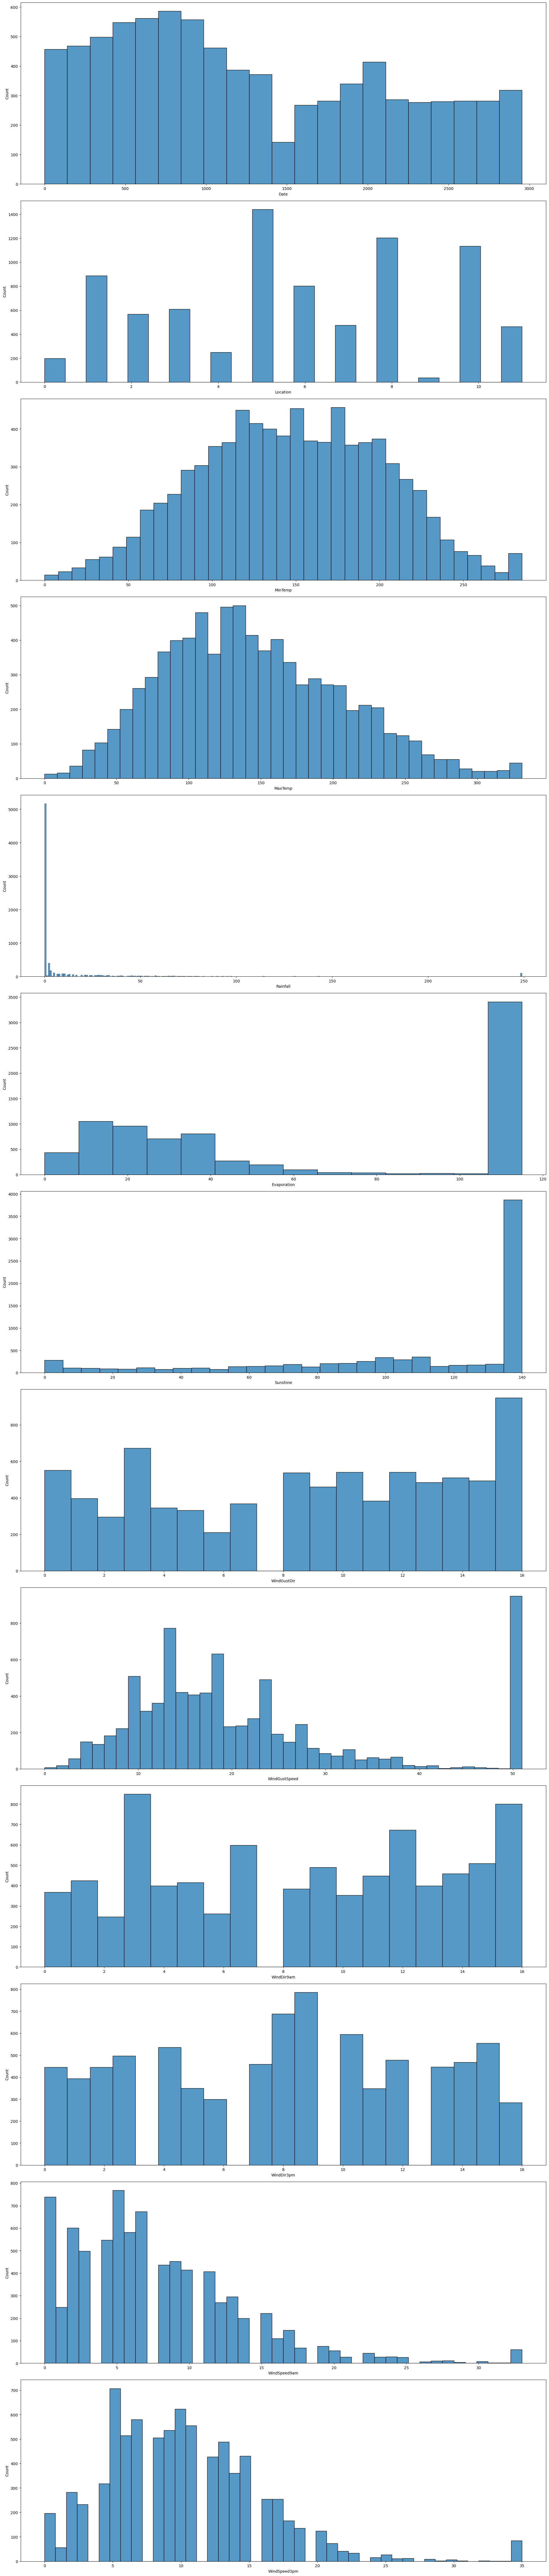

In [47]:
eda.all_col_histplots()

We can check that the Max and min temperatures follow normal distribution while other are irregular

In [48]:
eda.check_skew()

Date                          0.364940
Location                     -0.051895
MinTemp                      -0.009981
MaxTemp                       0.435122
Rainfall                      3.522192
Evaporation                   0.113886
Sunshine                     -1.134449
WindGustDir                  -0.180395
WindGustSpeed                 1.167817
WindDir9am                   -0.068586
WindDir3pm                   -0.068038
WindSpeed9am                  1.260353
WindSpeed3pm                  1.048351
Humidity9am                  -0.236525
Humidity3pm                   0.204441
Pressure9am                   0.368755
Pressure3pm                   0.354707
Cloud9am                     -0.609651
Cloud3pm                     -0.533534
Temp9am                       0.033762
Temp3pm                       0.518784
RainToday                     1.429639
RainTomorrow                  1.201422
Rainfall_quantity_tomorrow    3.498011
Rainfall_tomorrow_pred        1.230028
dtype: float64


we can see that there is not much skewness in the data except for some variables like Rainfall, and some other

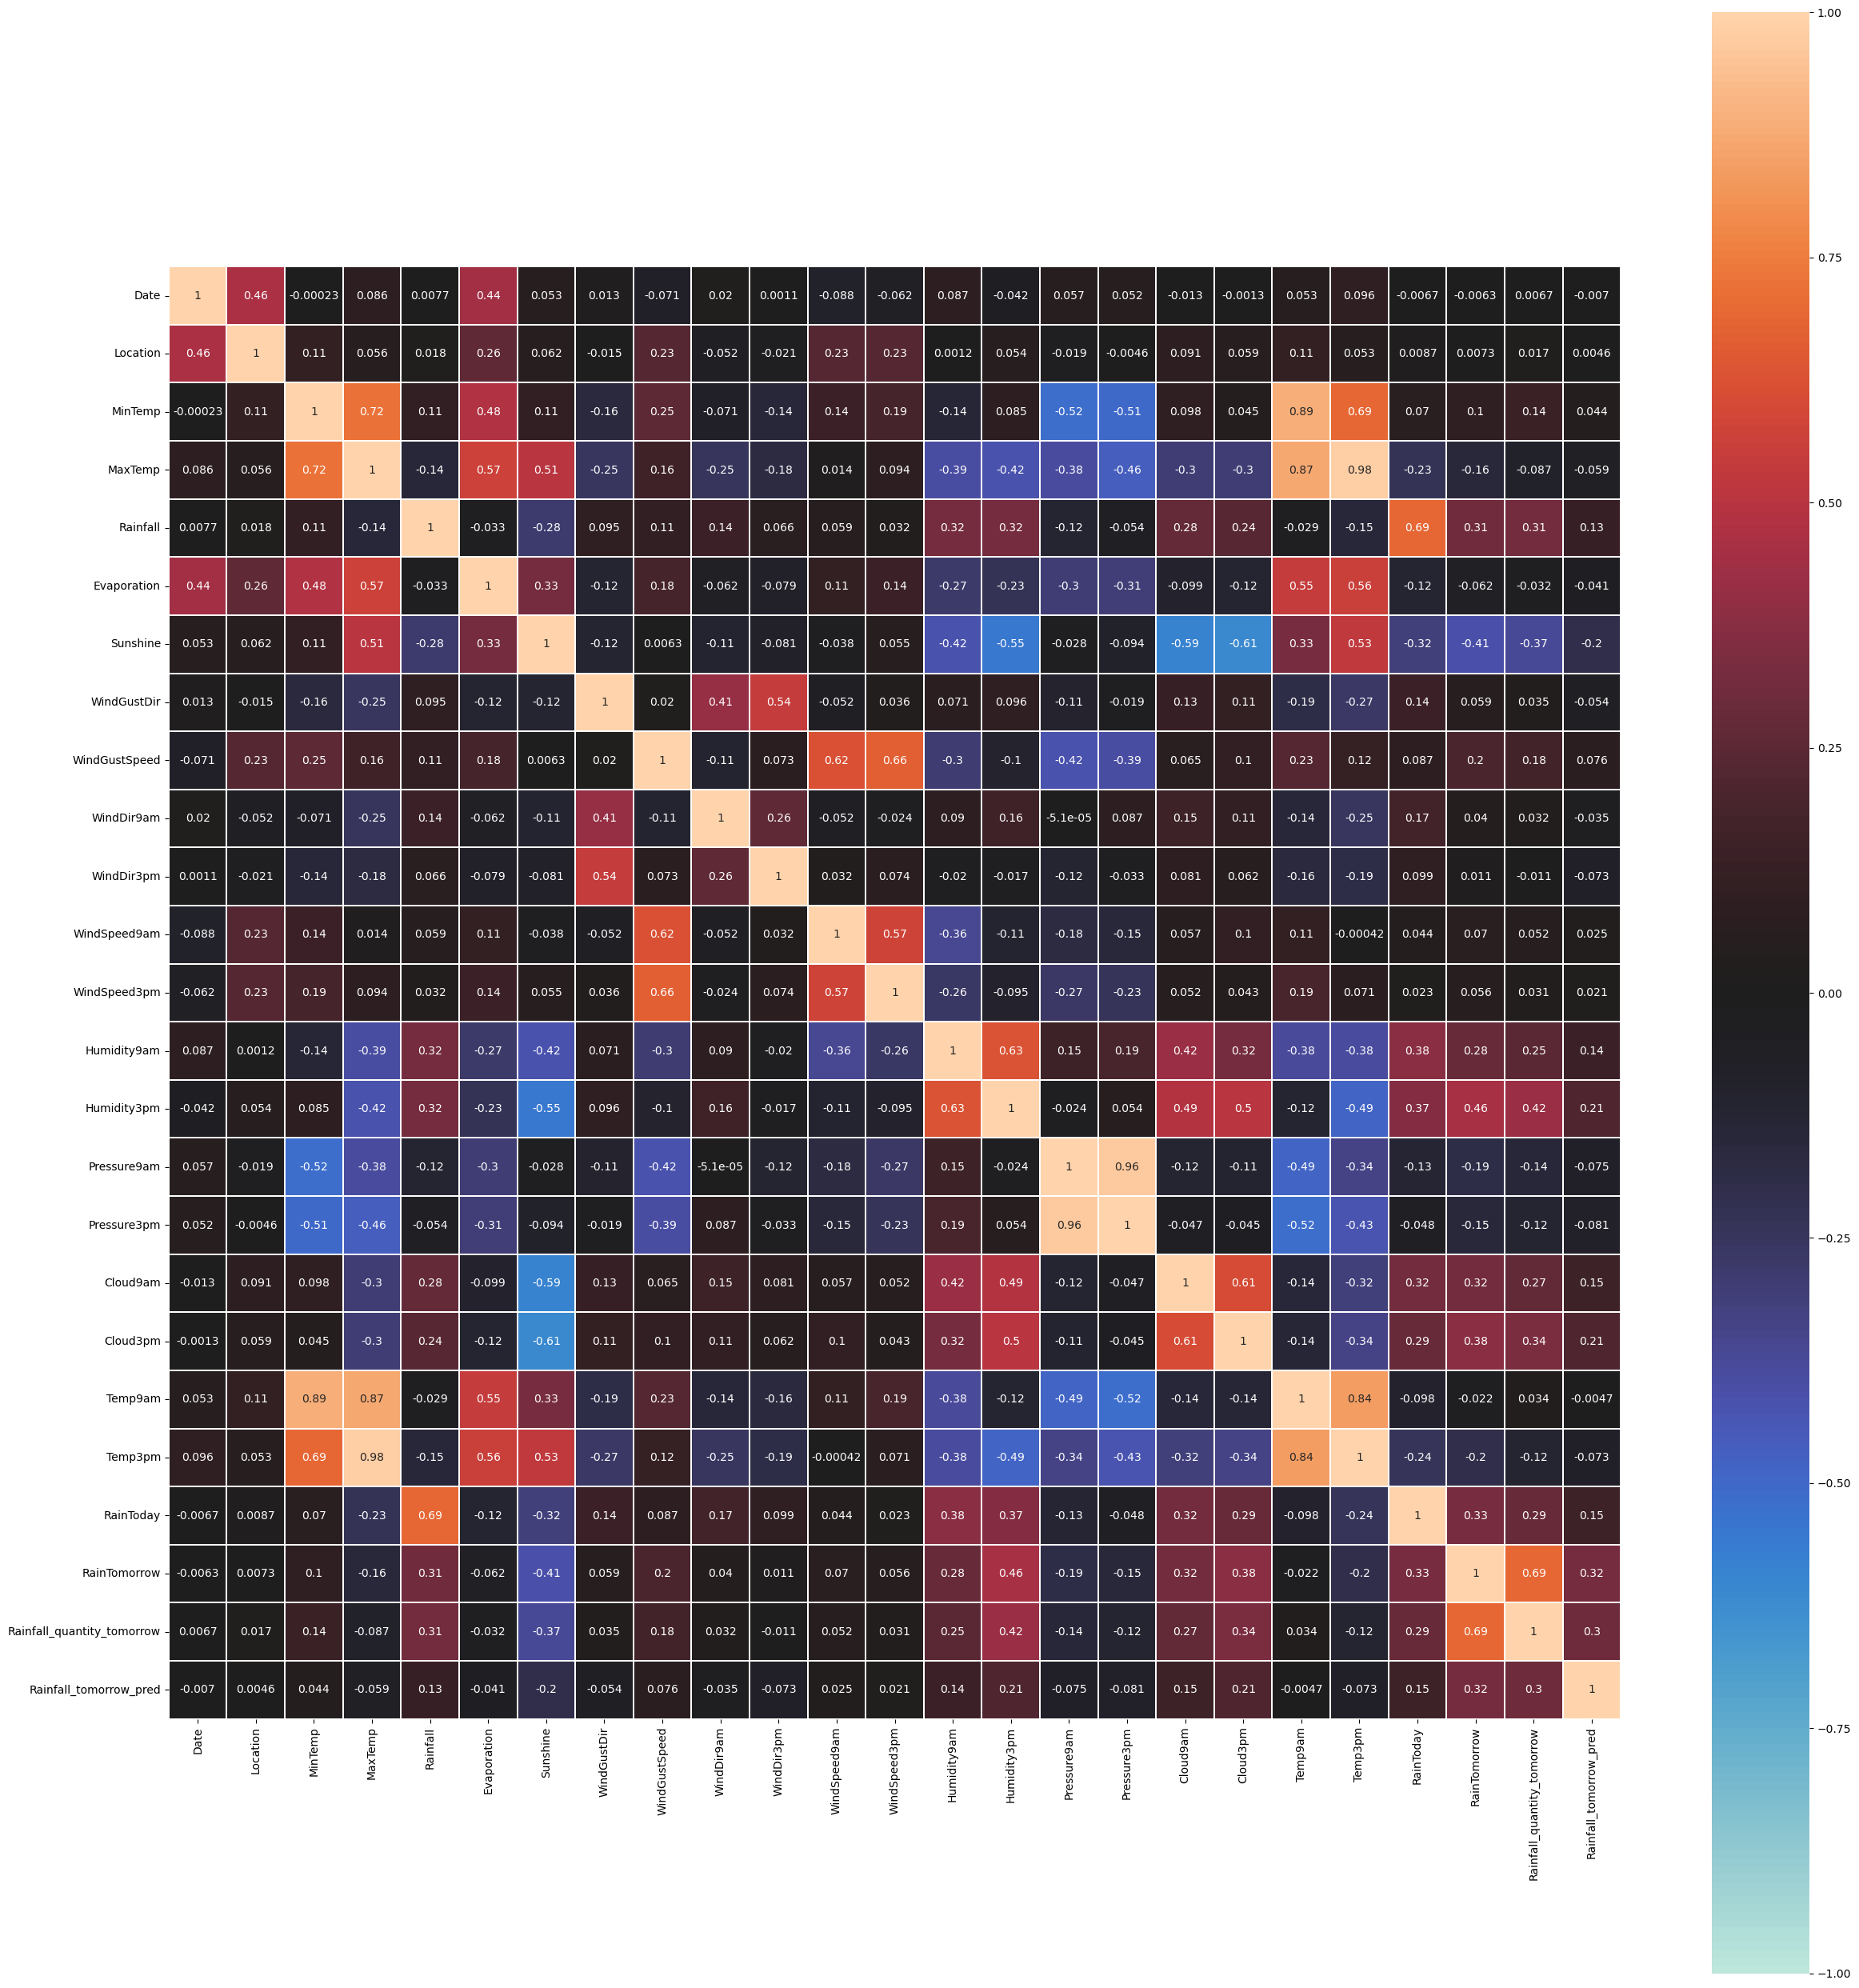

In [123]:
eda.corr_plot(df)

Sunshine is a bit correlated with rainfall_quantity_tomorrow except that we can see that there is no much correlation that might hamper our job. We can drop the column RainTomorrow as we no more need it. Also we need to handle skewness, and imbalances in target variables using upsampling. Below is the code

Handling skewness()

In [49]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_quantity_tomorrow,Rainfall_tomorrow_pred
0,0.0,1.0,149.0,134.0,5.0,115.0,140.0,13.0,20.0,13.0,...,88.0,101.0,8.0,9.0,145.0,133.0,0.0,0.0,0.0,0.0
1,1.0,1.0,89.0,156.0,0.0,115.0,140.0,14.0,20.0,6.0,...,117.0,108.0,9.0,9.0,148.0,158.0,0.0,0.0,0.0,0.0
2,2.0,1.0,144.0,162.0,0.0,115.0,140.0,15.0,21.0,13.0,...,87.0,117.0,9.0,2.0,186.0,147.0,0.0,0.0,0.0,0.0
3,3.0,1.0,107.0,185.0,0.0,115.0,140.0,4.0,9.0,9.0,...,187.0,158.0,9.0,9.0,157.0,180.0,0.0,0.0,8.0,0.0
4,4.0,1.0,190.0,228.0,8.0,115.0,140.0,13.0,18.0,1.0,...,119.0,90.0,7.0,8.0,154.0,212.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,2949.0,9.0,89.0,111.0,0.0,115.0,140.0,0.0,15.0,2.0,...,283.0,263.0,9.0,9.0,86.0,118.0,0.0,0.0,0.0,0.0
8064,2950.0,9.0,50.0,123.0,0.0,115.0,140.0,0.0,13.0,2.0,...,258.0,242.0,9.0,9.0,70.0,124.0,0.0,0.0,0.0,0.0
8065,2951.0,9.0,43.0,139.0,0.0,115.0,140.0,0.0,13.0,9.0,...,257.0,233.0,9.0,9.0,77.0,139.0,0.0,0.0,0.0,0.0
8066,2952.0,9.0,51.0,158.0,0.0,115.0,140.0,6.0,8.0,9.0,...,246.0,221.0,9.0,9.0,85.0,160.0,0.0,0.0,0.0,0.0


In [50]:
X,y = df.drop(columns=['Rainfall_quantity_tomorrow','Rainfall_tomorrow_pred','RainTomorrow']),df[['Rainfall_quantity_tomorrow','Rainfall_tomorrow_pred']]

In [51]:
X.shape

(8068, 22)

In [52]:
y.shape

(8068, 2)

In [57]:
enc = Encoder(X)
X = enc.do_yeo(X)

In [58]:
X

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,0.0,1.0,149.0,134.0,1.052999,115.0,1108.932639,13.0,3.383748,13.0,...,5.584725,60.0,16.0,88.0,101.0,11.621456,12.649923,145.0,28.011427,-0.0
1,1.0,1.0,89.0,156.0,-0.000000,115.0,1108.932639,14.0,3.383748,6.0,...,5.304302,33.0,19.0,117.0,108.0,13.366147,12.649923,148.0,31.124164,-0.0
2,2.0,1.0,144.0,162.0,-0.000000,115.0,1108.932639,15.0,3.441097,13.0,...,5.855520,27.0,24.0,87.0,117.0,13.366147,2.301717,186.0,29.781814,-0.0
3,3.0,1.0,107.0,185.0,-0.000000,115.0,1108.932639,4.0,2.493276,9.0,...,2.933259,34.0,10.0,187.0,158.0,13.366147,12.649923,157.0,33.697464,-0.0
4,4.0,1.0,190.0,228.0,1.162669,115.0,1108.932639,13.0,3.260982,1.0,...,5.013125,71.0,27.0,119.0,90.0,9.924131,11.032726,154.0,37.217673,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,2949.0,9.0,89.0,111.0,-0.000000,115.0,1108.932639,0.0,3.052130,2.0,...,4.392738,52.0,27.0,283.0,263.0,13.366147,12.649923,86.0,26.026377,-0.0
8064,2950.0,9.0,50.0,123.0,-0.000000,115.0,1108.932639,0.0,2.891529,2.0,...,3.708103,48.0,21.0,258.0,242.0,13.366147,12.649923,70.0,26.832276,-0.0
8065,2951.0,9.0,43.0,139.0,-0.000000,115.0,1108.932639,0.0,2.891529,9.0,...,3.334254,40.0,18.0,257.0,233.0,13.366147,12.649923,77.0,28.779194,-0.0
8066,2952.0,9.0,51.0,158.0,-0.000000,115.0,1108.932639,6.0,2.370437,9.0,...,2.933259,45.0,15.0,246.0,221.0,13.366147,12.649923,85.0,31.364004,-0.0


UpSampling

In [59]:
X.skew()

Date             0.364940
Location        -0.051895
MinTemp         -0.009981
MaxTemp          0.435122
Rainfall         0.736564
Evaporation      0.113886
Sunshine        -0.808708
WindGustDir     -0.180395
WindGustSpeed    0.001414
WindDir9am      -0.068586
WindDir3pm      -0.068038
WindSpeed9am    -0.041391
WindSpeed3pm     0.030440
Humidity9am     -0.236525
Humidity3pm      0.204441
Pressure9am      0.368755
Pressure3pm      0.354707
Cloud9am        -0.502728
Cloud3pm        -0.438734
Temp9am          0.033762
Temp3pm         -0.008186
RainToday        1.148235
dtype: float64

Now we can see that skewness is removed

In [60]:
smote = SMOTE()

In [61]:
X.shape

(8068, 22)

In [62]:
y.shape

(8068, 2)

In [63]:
X_predprob, y_predprob = smote.fit_resample(X, y['Rainfall_tomorrow_pred'])

In [64]:
X_predprob.shape

(12294, 22)

In [65]:
y_predprob.shape

(12294,)

In [66]:
len(y['Rainfall_quantity_tomorrow'].unique())

249

In [67]:
y['Rainfall_quantity_tomorrow'].value_counts()

Rainfall_quantity_tomorrow
0.0      5228
2.0       404
3.0       176
5.0       111
10.0       84
         ... 
241.0       1
235.0       1
174.0       1
171.0       1
191.0       1
Name: count, Length: 249, dtype: int64

In [68]:
X_regprob, y_regprob = X,y['Rainfall_quantity_tomorrow'] # Since there is not much differenciation in this problem, we need not to oversample

In [69]:
X_predprob = enc.standard_scaler(X_predprob)

In [70]:
X_regprob = enc.standard_scaler(X_regprob)

In [71]:
X_regprob.shape

(8068, 22)

In [72]:
y_regprob.shape

(8068,)

### Checking outlier influence

In [73]:
eda = EDA()
vif = eda.get_vif(X_regprob)

       values       features
0    1.668414           Date
1    1.525545       Location
2    7.194934        MinTemp
3    9.807417        MaxTemp
4    5.110453       Rainfall
5    3.297984    Evaporation
6    2.903202       Sunshine
7    1.930186    WindGustDir
8    1.827003  WindGustSpeed
9    1.423895     WindDir9am
10   1.478290     WindDir3pm
11   2.110930   WindSpeed9am
12   1.828182   WindSpeed3pm
13   2.811140    Humidity9am
14   2.805728    Humidity3pm
15  40.362353    Pressure9am
16  38.704881    Pressure3pm
17   2.212694       Cloud9am
18   2.065412       Cloud3pm
19  11.807326        Temp9am
20   8.014989        Temp3pm
21   4.700797      RainToday


In [74]:
eda = EDA()
vif = eda.get_vif(X_predprob)

       values       features
0    1.692903           Date
1    1.535097       Location
2    8.197132        MinTemp
3    9.935232        MaxTemp
4    5.362173       Rainfall
5    3.466001    Evaporation
6    3.088729       Sunshine
7    1.975385    WindGustDir
8    1.831325  WindGustSpeed
9    1.426507     WindDir9am
10   1.521540     WindDir3pm
11   2.229292   WindSpeed9am
12   1.910235   WindSpeed3pm
13   3.004984    Humidity9am
14   3.040235    Humidity3pm
15  45.948541    Pressure9am
16  44.067842    Pressure3pm
17   2.119933       Cloud9am
18   1.987865       Cloud3pm
19  13.279147        Temp9am
20   8.618394        Temp3pm
21   4.899998      RainToday


In [86]:
X_regprob.drop(columns=['Pressure9am','Pressure3pm'],inplace=True)

In [87]:
X_regprob.corr()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
Date,1.000000,0.463820,0.009770,0.094694,0.012077,0.251538,0.332996,0.151771,0.158378,0.082253,0.040370,-0.080743,-0.035679,0.091550,-0.014998,0.075846,0.088280,0.059792,0.129799,-0.007578
Location,0.463820,1.000000,0.108953,0.054828,0.011942,0.155085,0.157379,0.012253,0.229540,-0.083548,-0.019239,0.245830,0.216279,0.002885,0.054520,0.023780,0.004413,0.110966,0.070493,0.005441
MinTemp,0.009770,0.108953,1.000000,0.689558,0.065439,0.026751,-0.055981,-0.117630,0.219666,-0.123196,-0.141380,0.189087,0.170417,-0.104454,0.082421,-0.038790,-0.085833,0.882128,0.651071,0.072845
MaxTemp,0.094694,0.054828,0.689558,1.000000,-0.260776,0.070516,0.159466,-0.181279,0.150710,-0.232999,-0.175730,0.023157,0.097880,-0.374375,-0.392517,-0.218502,-0.209848,0.837328,0.919152,-0.225854
Rainfall,0.012077,0.011942,0.065439,-0.260776,1.000000,-0.004992,-0.144417,0.149517,0.075985,0.175185,0.120872,0.031935,0.010721,0.424276,0.385149,0.183019,0.158438,-0.120742,-0.264122,0.886050
Evaporation,0.251538,0.155085,0.026751,0.070516,-0.004992,1.000000,0.742687,0.211660,0.162464,0.152661,0.049616,-0.269048,-0.145226,0.148261,0.051779,0.338414,0.313764,0.000304,0.084002,-0.022383
Sunshine,0.332996,0.157379,-0.055981,0.159466,-0.144417,0.742687,1.000000,0.155144,0.106402,0.098237,0.025313,-0.231834,-0.113054,-0.040191,-0.175700,0.108511,0.077585,0.032073,0.185534,-0.140399
WindGustDir,0.151771,0.012253,-0.117630,-0.181279,0.149517,0.211660,0.155144,1.000000,0.352466,0.415928,0.506995,-0.148882,-0.026359,0.114894,0.132354,0.042325,0.039646,-0.141181,-0.166162,0.112155
WindGustSpeed,0.158378,0.229540,0.219666,0.150710,0.075985,0.162464,0.106402,0.352466,1.000000,-0.007989,0.131689,0.252595,0.368727,-0.151483,0.016271,-0.140498,-0.102325,0.202828,0.139947,0.064233
WindDir9am,0.082253,-0.083548,-0.123196,-0.232999,0.175185,0.152661,0.098237,0.415928,-0.007989,1.000000,0.256605,-0.292149,-0.147523,0.216794,0.179236,0.123050,0.095289,-0.188017,-0.207848,0.142025


We have high multicollinearity. We must use PCA to reduce it's effect on regression or we can just drop the columns. We are using PCA here

# Training

### Regressors

In [88]:
X_regprob

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,-1.516149,-1.504943,0.027770,-0.164525,1.000725,1.120159,0.842834,0.822259,0.132839,0.889336,1.270998,0.724077,0.576794,0.181693,-1.561148,0.700325,1.085542,-0.162430,-0.035542,-0.579053
1,-1.514968,-1.504943,-1.057221,0.190004,-0.727605,1.120159,0.842834,1.014838,0.132839,-0.506067,1.484600,-1.020088,0.422164,-1.407516,-1.403222,1.062472,1.085542,-0.109864,0.356865,-0.579053
2,-1.513787,-1.504943,-0.062646,0.286694,-0.727605,1.120159,0.842834,1.207418,0.215796,0.889336,1.484600,0.585719,0.726115,-1.760674,-1.140012,1.062472,-1.235818,0.555981,0.187642,-0.579053
3,-1.512606,-1.504943,-0.731723,0.657337,-0.727605,1.120159,0.842834,-0.910958,-1.155248,0.091963,-1.719436,-0.064148,-0.885267,-1.348656,-1.877000,1.062472,1.085542,0.047836,0.681269,-0.579053
4,-1.511425,-1.504943,0.769181,1.350280,1.180730,1.120159,0.842834,0.822259,-0.044744,-1.502784,-0.224219,-0.480735,0.261605,0.829148,-0.982086,0.348009,0.722764,-0.004730,1.125044,-0.579053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,1.966204,1.015754,-1.057221,-0.535169,-0.727605,1.120159,0.842834,-1.681276,-0.346853,-1.303441,-1.719436,0.283455,-0.080486,-0.289184,-0.982086,1.062472,1.085542,-1.196241,-0.285787,-0.579053
8064,1.967385,1.015754,-1.762465,-0.341790,-0.727605,1.120159,0.842834,-1.681276,-0.579166,-1.303441,-1.719436,0.283455,-0.458005,-0.524622,-1.297938,1.062472,1.085542,-1.476597,-0.184191,-0.579053
8065,1.968566,1.015754,-1.889047,-0.083950,-0.727605,1.120159,0.842834,-1.681276,-0.579166,0.091963,-1.505833,0.116430,-0.664152,-0.995499,-1.455864,1.062472,1.085542,-1.353941,0.061247,-0.579053
8066,1.969747,1.015754,-1.744381,0.222234,-0.727605,1.120159,0.842834,-0.525799,-1.332936,0.091963,-1.078629,0.116430,-0.885267,-0.701201,-1.613790,1.062472,1.085542,-1.213764,0.387101,-0.579053


In [89]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

regressors = {
    'LinearRegression': (LinearRegression(),{'fit_intercept':[True,False]}),
    'Ridge': (Ridge(),{'alpha':[0.5,1.0],'fit_intercept':[True,False]}),
    'Logistic': (LogisticRegression(),{'C':[0.1, 1, 10]}),
    'RandomForest': (RandomForestRegressor(), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    'GradientBoosting': (GradientBoostingRegressor(), {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.01]}),
    'SVM': (SVR(), {'C': [1, 10], 'kernel': ['linear', 'rbf']}),
    'KNN': (KNeighborsRegressor(), {'n_neighbors':[5,10]}),
    'DecisionTree': (DecisionTreeRegressor(),{'max_depth':[100,200],'max_leaf_nodes':[50,100]})
}

In [90]:
X_regprob.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday'],
      dtype='object')

In [91]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
X_pca = pca.fit_transform(X_regprob)

In [92]:
X_regprob.shape

(8068, 20)

In [93]:
X_pca.shape

(8068, 14)

In [95]:
bscore = 0
bmodel = ''
b_models = []

pca = PCA(n_components=i)
X_pca = pca.fit_transform(X_regprob)
for cl, (clas, param_grid) in regressors.items():

    grid_search = GridSearchCV(clas, param_grid=param_grid, cv=5, scoring='r2')
    grid_search.fit(X_pca, y_regprob)
    print(grid_search.best_score_)
    if grid_search.best_score_ > bscore:
        bscore = grid_search.best_score_
        bmodel = cl
        params = grid_search.best_params_
print(f"Best model: {bmodel} with accuracy {bscore:.4f} when PCA comp is {i}")
b_models.append([grid_search.best_estimator_,i,grid_search.best_params_,grid_search.best_score_])

0.0364963787039567
0.03649756242999695


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.16412408802086356
0.0685887498955658
0.04555253793198262
-0.10410552450239866
-0.039106872039220766
-0.09004742795860939
Best model: RandomForest with accuracy 0.0686 when PCA comp is 2


NameError: name 'b_models' is not defined

In [241]:
X = X_regprob.drop(columns=['Pressure9am','Pressure3pm'])

In [242]:
pca = PCA(0.95)
X_pca = pca.fit_transform(X)

In [243]:
bscore = 0
bmodel = ''
b_models = []
for i in range(2,21):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_regprob)
    for cl, (clas, param_grid) in regressors.items():

        grid_search = GridSearchCV(clas, param_grid=param_grid, cv=5, scoring='r2')
        grid_search.fit(X_pca, y_regprob)
        print(grid_search.best_score_)
        if grid_search.best_score_ > bscore:
            bscore = grid_search.best_score_
            bmodel = cl
            params = grid_search.best_params_
    print(f"Best model: {bmodel} with accuracy {bscore:.4f} when PCA comp is {i}")
    b_models.append([grid_search.best_estimator_,i,grid_search.best_params_,grid_search.best_score_])

-0.023876703545130874
-0.023869206634241504


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.1636605201370489
0.04123198002758155
0.011268724064415304
-0.08890593661978348
-0.15153050390021147
-0.11919079546896101
Best model: RandomForest with accuracy 0.0412 when PCA comp is 2
0.12400608600397596
0.12401152164609619


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.2988737465090804
0.18877897097034788
0.16930839114366988
0.036805504174719575
0.012452664274827541
0.04401084721484423
Best model: RandomForest with accuracy 0.1888 when PCA comp is 3
0.1289933036879127
0.12900023705092187


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.2934372200817476
0.22845966641256213
0.19293800030860123
0.05369402071277074
0.06367523012030515
0.06414251432959735
Best model: RandomForest with accuracy 0.2285 when PCA comp is 4
0.12267382107044777
0.12268290447724342


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.33509073125013494
0.21475063256132582
0.18665988588393062
0.05446875192538216
0.04252223230648944
0.05113891556772474
Best model: RandomForest with accuracy 0.2285 when PCA comp is 5
0.12912772800742328
0.12913545075750618


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.38241932023531405
0.17723960992246957
0.17643601279176607
0.05103704322824516
0.03574554984355751
0.05060430619789587
Best model: RandomForest with accuracy 0.2285 when PCA comp is 6
0.13218203190249897
0.13219135532373266


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.39785913265196216
0.21855262247633567
0.19699513602362678
0.07698921180430365
0.06974142633853961
0.05610826114293901
Best model: RandomForest with accuracy 0.2285 when PCA comp is 7
0.13346603188494338
0.1334754930123353


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.40804522422548484
0.21421832455219664
0.18217847790143699
0.06395842183736403
0.02947065091550203
0.03243315647307647
Best model: RandomForest with accuracy 0.2285 when PCA comp is 8
0.12797638298664443
0.1279914832241127


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.4214445665426515
0.20416256181298992
0.18978919878673656
0.0612612971970042
0.03691526364888433
0.014881786896770999
Best model: RandomForest with accuracy 0.2285 when PCA comp is 9
0.12457837775822363
0.12459521280145873


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

-0.3996379467002046
0.19612288233324165
0.1879634651991012
0.06945355524944549
0.05025928613170638
0.022203223311036635
Best model: RandomForest with accuracy 0.2285 when PCA comp is 10
0.12297916653653469
0.12300019573384754


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

We can see that we are not going beyong 0.2285

In [ ]:
b_m

### Classifiers

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


classifiers = {
    'RandomForest' : (RandomForestClassifier(), {'n_estimators':[100,200,300,400,500], 'max_depth':[None, 10,20,30, 40, 50]}),
    'GradientBoost': (GradientBoostingClassifier(),{'n_estimators':[50,100,150,200,250],'learning_rate':[0.05,0.1]}),
    'SVC' : (SVC(),{'C':[1,5,10],'kernel':['linear','rbf']}),
    'KNN': (KNeighborsClassifier(),{'n_neighbors':[5,10,15,20,25]}),
    'DecisionTree': (DecisionTreeClassifier(),{'max_depth':[100,150,200,250],'max_leaf_nodes':[50,100]})
}

In [106]:
bscore = 0
bmodel = ''

for cl, (clas, param_grid) in classifiers.items():
    
    grid_search = GridSearchCV(clas, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_predprob,y_predprob)
    print(grid_search.best_score_)
    if grid_search.best_score_ > bscore:
        bscore = grid_search.best_score_
        bmodel = cl
        params = grid_search.best_params_
print(f"Best model: {bmodel} with accuracy {bscore:.4f}")

0.6202156704369892
0.5183006845215148
0.6010209419839311
0.5787341365025971
0.5213112953164195
Best model: RandomForest with accuracy 0.6202


In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_score_

In [ ]:
import joblib

joblib.dump(grid_search.best_estimator_, 'model_pred.joblib')
model = joblib.load('model_pred.joblib')

In [ ]:
import pickle
file = open('model_reg', 'wb')

# dump information to that file
pickle.dump(data, file)

# close the file
file.close()

In [156]:
import pickle
file = open('model_reg', 'rb')
pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'model_reg'

In [ ]:
import os
os.system("shutdown /s /t 1") 

In [324]:
data = X.iloc[[0]]
print(data)
model.predict(data)

        Age  Workclass    Fnlwgt  Education_num  Marital_status  Occupation  \
0  0.780797   1.430094 -1.253084        1.11995       -0.389862   -0.737056   

   Relationship      Race       Sex  Capital_gain  Capital_loss  \
0     -1.284144  0.971709  1.177154     -0.458321     -0.815118   

   Hours_per_week  Native_country  
0       -2.331953        0.748944  


array([' <=50K'], dtype=object)

In [325]:
y.iloc[0]

' <=50K'

In [ ]:
y_pred = lr_gs.best_estimator_.predict(X)
from sklearn.metrics import confusion_matrix
print confusion_matrix(y, y_pred)

We got really good accuracy. Hence we can finalize our model as DecisionTree with max_depth=150, max_leaf_nodes=100.